# Configuration

## Imports

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from pathlib import Path
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update(
    {
        "figure.figsize": (14, 7),
        "font.size": 11,
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        "figure.dpi": 100,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "font.family": "sans-serif",
    }
)

# Professional color palettes - using darker, more distinguishable colors
model_colors = sns.color_palette("dark", 8)
benchmark_colors = sns.color_palette("dark", 10)  # Darker palette for better visibility
method_palette = {
    "Baseline": "#2C3E50",
    "Thinkless": "#E74C3C",
    "ThinkBrake": "#3498DB",
}
threshold_palette = sns.color_palette("Blues", 6)[1:]  # Skip lightest
bar_colors = [
    "#2C3E50",
    "#3498DB",
    "#E67E22",
    "#27AE60",
    "#9B59B6",
    "#1ABC9C",
    "#E74C3C",
    "#95A5A6",
]

# Darker, more distinguishable line colors
line_colors = [
    "#1A5276",  # Dark blue
    "#B03A2E",  # Dark red
    "#1E8449",  # Dark green
    "#7D3C98",  # Dark purple
    "#B9770E",  # Dark orange
    "#117A65",  # Dark teal
    "#6C3483",  # Purple
    "#1F618D",  # Steel blue
]

markers = ["o", "s", "^", "D", "v", "p", "h", "*"]

## Helper Functions

In [2]:
def calc_subplot_layout(n_items, max_cols=4):
    if n_items == 0:
        return 1, 1, (6, 4)

    cols = min(n_items, max_cols)
    rows = math.ceil(n_items / cols)
    fig_width = 5.5 * cols
    fig_height = 4.5 * rows
    return rows, cols, (fig_width, fig_height)


def create_dynamic_subplots(n_items, max_cols=4, sharey=False):
    rows, cols, figsize = calc_subplot_layout(n_items, max_cols)
    fig, axes = plt.subplots(rows, cols, figsize=figsize, sharey=sharey)

    if n_items == 1:
        axes = np.array([axes])
    else:
        axes = np.array(axes).flatten()

    for i in range(n_items, len(axes)):
        axes[i].set_visible(False)

    return fig, axes


def add_value_labels(ax, bars, fmt=".1f", rotation=0, fontsize=9, offset=0.5):
    """Add value labels on top of bars"""
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.annotate(
                f"{height:{fmt}}",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, offset),
                textcoords="offset points",
                ha="center",
                va="bottom",
                fontsize=fontsize,
                rotation=rotation,
            )


def format_model_name(name, short_names):
    """Format model name for display"""
    return short_names.get(name, name.split("/")[-1])


def load_detailed_results(model_dir, benchmark, method="rollout"):
    """Load detailed results from JSONL files"""
    base_path = Path(f"../outputs/{model_dir}")

    # Determine category (math or general)
    math_benchmarks = ["gsm8k", "math500", "aime2024", "aime2025"]
    general_benchmarks = ["gpqa-diamond"]

    if benchmark in math_benchmarks:
        category = "math"
    elif benchmark in general_benchmarks:
        category = "general"
    else:
        return None

    if method == "rollout":
        file_path = base_path / category / "rollout" / f"{benchmark}_result.jsonl"
    else:
        # For thinkbrake, method should be like "threshold_1.0"
        file_path = (
            base_path / category / "thinkbrake" / method / f"{benchmark}_result.jsonl"
        )

    if not file_path.exists():
        return None

    results = []
    with open(file_path, "r") as f:
        for line in f:
            if line.strip():
                results.append(json.loads(line))
    return results

## Load Dataset

In [3]:
with open("../outputs/leaderboard_rollout.json", "r") as f:
    rollout_data = json.load(f)

with open("../outputs/leaderboard_thinkbrake.json", "r") as f:
    thinkbrake_data = json.load(f)


INCLUDE_MODELS = [
    "Qwen_Qwen3-4B-Thinking-2507",
    "Qwen_Qwen3-4B",
    "Qwen_Qwen3-14B",
    "Qwen_Qwen3-32B",
    "deepseek-ai_DeepSeek-R1-Distill-Llama-8B",
    "deepseek-ai_DeepSeek-R1-Distill-Qwen-7B",
    "openai_gpt-oss-20b",
    "microsoft_phi-4-reasoning",
]

INCLUDE_BENCHMARKS = [
    "gsm8k",
    "math500",
    "aime2024",
    "aime2025",
    "gpqa-diamond",
    "mmlu-redux",
]

INCLUDE_THRESHOLDS = [
    # "0.0",
    "0.1",
    "0.25",
    "1.0",
    "2.5",
    # "5.0",
]

model_name_map = {
    "Qwen_Qwen3-4B-Thinking-2507": "Qwen/Qwen3-4B-Thinking-2507",
    "Qwen_Qwen3-4B": "Qwen/Qwen3-4B",
    "Qwen_Qwen3-14B": "Qwen/Qwen3-14B",
    "Qwen_Qwen3-32B": "Qwen/Qwen3-32B",
    "deepseek-ai_DeepSeek-R1-Distill-Llama-8B": "deepseek-ai/DeepSeek-R1-Distill-Llama-8B",
    "deepseek-ai_DeepSeek-R1-Distill-Qwen-7B": "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B",
    "openai_gpt-oss-20b": "openai/gpt-oss-20b",
    "microsoft_phi-4-reasoning": "microsoft/phi-4-reasoning",
}

short_names = {
    "Qwen/Qwen3-4B-Thinking-2507": "Qwen3-4B-2507",
    "Qwen/Qwen3-4B": "Qwen3-4B",
    "Qwen/Qwen3-14B": "Qwen3-14B",
    "Qwen/Qwen3-32B": "Qwen3-32B",
    "deepseek-ai/DeepSeek-R1-Distill-Llama-8B": "DS-R1-8B",
    "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B": "DS-R1-7B",
    "openai/gpt-oss-20b": "GPT-OSS-20B",
    "microsoft/phi-4-reasoning": "Phi-4-Reasoning",
}

benchmarks = INCLUDE_BENCHMARKS
thresholds = sorted(INCLUDE_THRESHOLDS, key=lambda x: float(x))

filtered_rollout_data = {k: v for k, v in rollout_data.items() if k in INCLUDE_MODELS}
filtered_thinkbrake_data = {
    k: v
    for k, v in thinkbrake_data.items()
    if k in [model_name_map.get(m, m) for m in INCLUDE_MODELS]
}
baseline_data = filtered_rollout_data

print("✅ Data loaded and filtered successfully!")
print(f"Included models (rollout): {list(filtered_rollout_data.keys())}")
print(f"Included models (thinkbrake): {list(filtered_thinkbrake_data.keys())}")
print(f"Included benchmarks: {benchmarks}")
print(f"Included thresholds: {thresholds}")

✅ Data loaded and filtered successfully!
Included models (rollout): ['Qwen_Qwen3-4B-Thinking-2507', 'Qwen_Qwen3-14B', 'deepseek-ai_DeepSeek-R1-Distill-Llama-8B', 'openai_gpt-oss-20b', 'Qwen_Qwen3-4B', 'deepseek-ai_DeepSeek-R1-Distill-Qwen-7B', 'Qwen_Qwen3-32B', 'microsoft_phi-4-reasoning']
Included models (thinkbrake): ['Qwen/Qwen3-4B-Thinking-2507', 'Qwen/Qwen3-14B', 'deepseek-ai/DeepSeek-R1-Distill-Llama-8B', 'openai/gpt-oss-20b', 'Qwen/Qwen3-4B', 'deepseek-ai/DeepSeek-R1-Distill-Qwen-7B', 'Qwen/Qwen3-32B', 'microsoft/phi-4-reasoning']
Included benchmarks: ['gsm8k', 'math500', 'aime2024', 'aime2025', 'gpqa-diamond', 'mmlu-redux']
Included thresholds: ['0.1', '0.25', '1.0', '2.5']


# Analysis


## Average Performance by Model

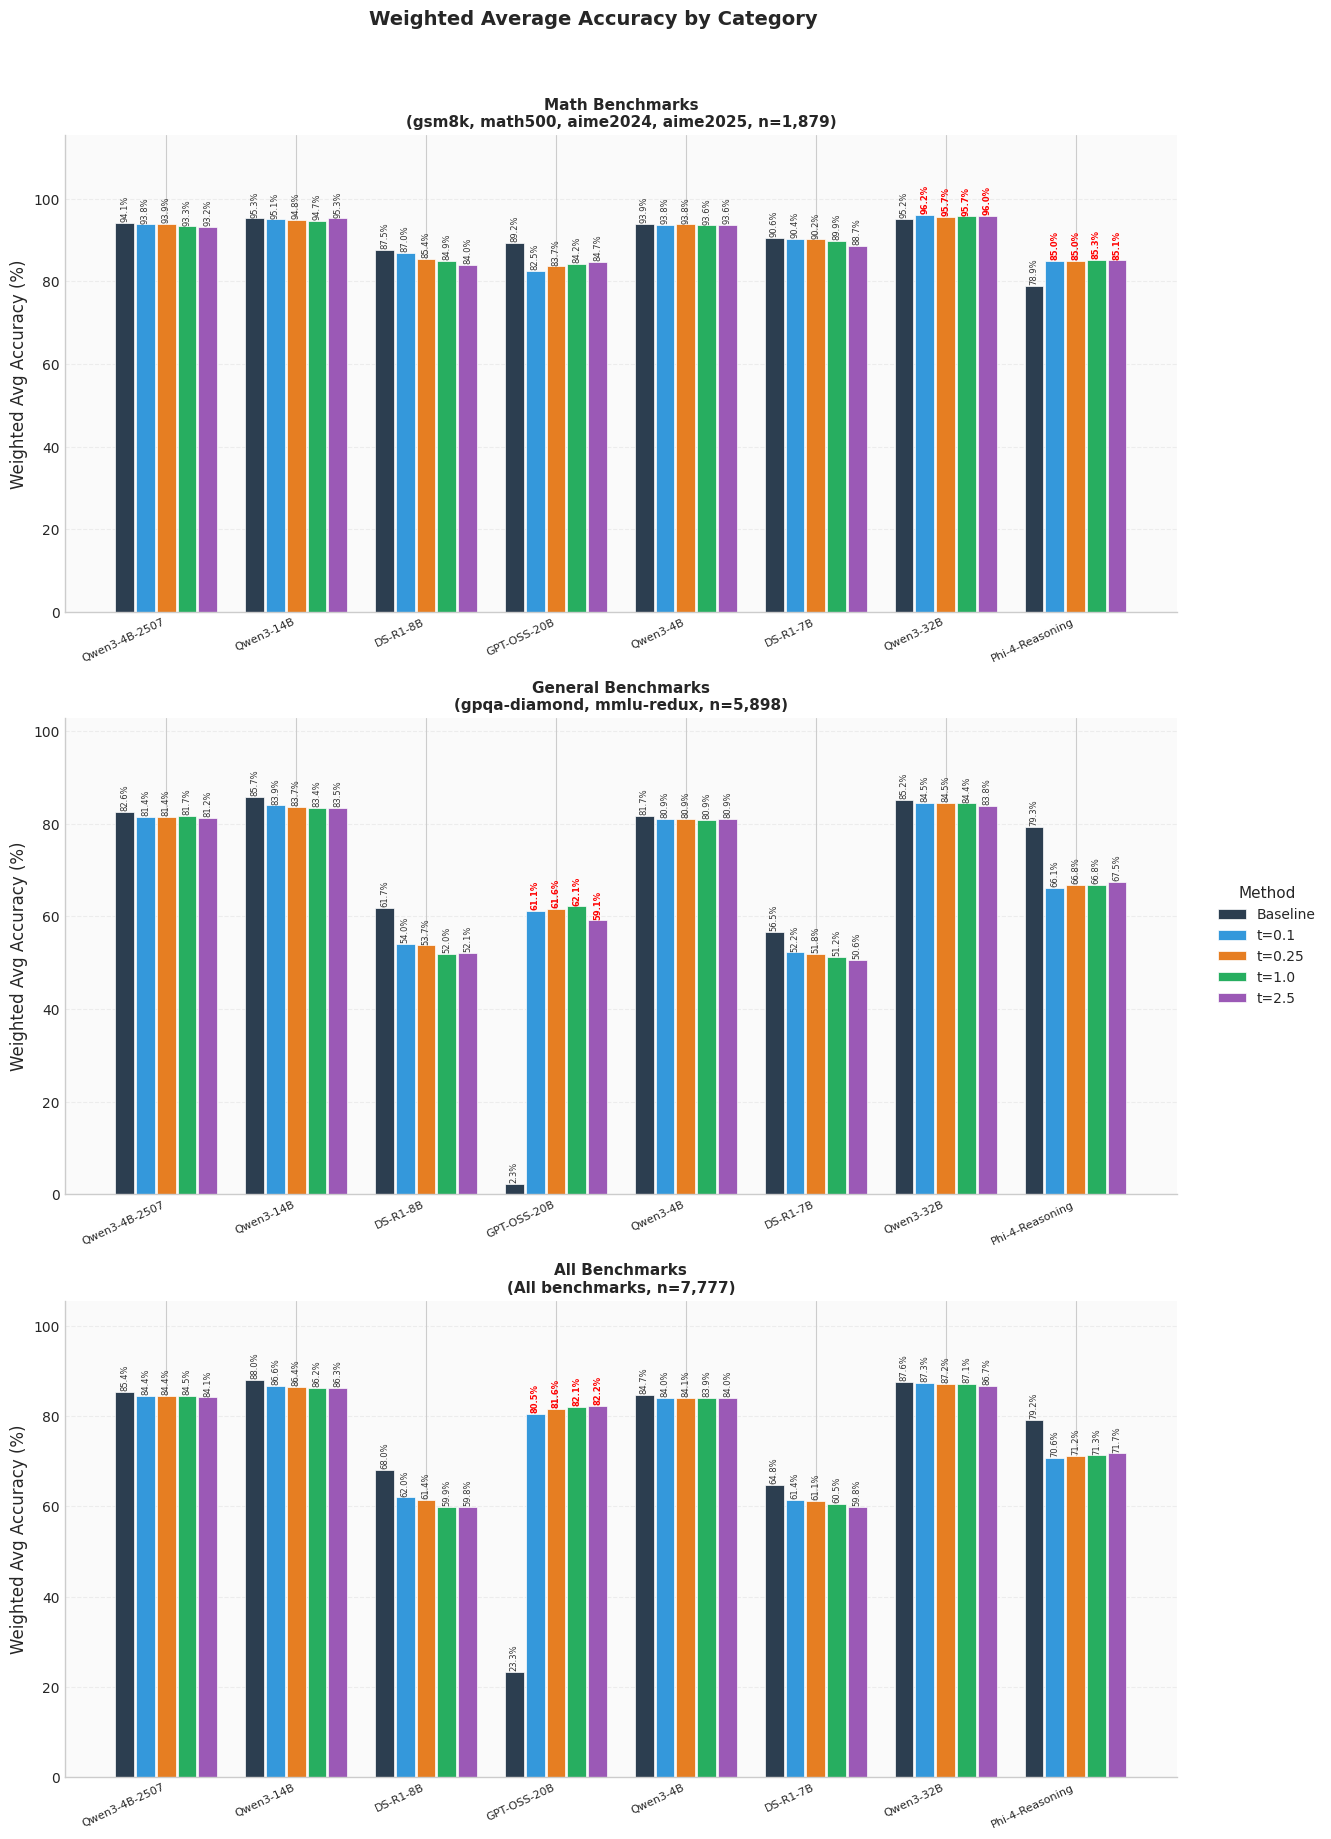


📊 Category Sample Breakdown:
  Math: 1,879 samples
  General: 5,898 samples
  Total: 7,777 samples


In [4]:
# Benchmark sample counts for weighted average
BENCHMARK_SAMPLES = {
    "gsm8k": 1319,
    "math500": 500,
    "aime2024": 30,
    "aime2025": 30,
    "gpqa-diamond": 198,
    "mmlu-redux": 5700,
}

# Benchmark categories
MATH_BENCHMARKS = ["gsm8k", "math500", "aime2024", "aime2025"]
GENERAL_BENCHMARKS = ["gpqa-diamond", "mmlu-redux"]


def compute_weighted_avg(accs, weights):
    """Compute weighted average"""
    if not accs:
        return None
    return np.average(accs, weights=weights)


def collect_category_data(
    model_data, thinkbrake_model_data, category_benchmarks, thresholds
):
    """Collect accuracy data for a specific category of benchmarks"""
    baseline_accs, baseline_weights = [], []
    threshold_data = {t: {"accs": [], "weights": []} for t in thresholds}

    for b in category_benchmarks:
        if b in model_data:
            baseline_accs.append(model_data[b]["accuracy"])
            baseline_weights.append(BENCHMARK_SAMPLES.get(b, 1))

            if thinkbrake_model_data and b in thinkbrake_model_data:
                for thresh in thresholds:
                    key = f"threshold_{thresh}"
                    if key in thinkbrake_model_data[b]:
                        threshold_data[thresh]["accs"].append(
                            thinkbrake_model_data[b][key]["accuracy"]
                        )
                        threshold_data[thresh]["weights"].append(
                            BENCHMARK_SAMPLES.get(b, 1)
                        )

    return baseline_accs, baseline_weights, threshold_data


# Collect data for all categories
avg_data_by_category = {"Math": [], "General": [], "All": []}

for rollout_name, rollout_model_data in filtered_rollout_data.items():
    try:
        mapped_name = model_name_map.get(rollout_name, rollout_name)
        display_name = short_names.get(mapped_name, rollout_name)
        thinkbrake_model_data = filtered_thinkbrake_data.get(mapped_name, None)

        for category, cat_benchmarks in [
            ("Math", MATH_BENCHMARKS),
            ("General", GENERAL_BENCHMARKS),
            ("All", benchmarks),
        ]:
            baseline_accs, baseline_weights, threshold_data = collect_category_data(
                rollout_model_data, thinkbrake_model_data, cat_benchmarks, thresholds
            )

            if baseline_accs:
                baseline_avg = compute_weighted_avg(baseline_accs, baseline_weights)
                avg_data_by_category[category].append(
                    {
                        "model": display_name,
                        "type": "Baseline",
                        "avg_accuracy": baseline_avg,
                    }
                )

                for thresh in thresholds:
                    if threshold_data[thresh]["accs"]:
                        avg_data_by_category[category].append(
                            {
                                "model": display_name,
                                "type": f"t={thresh}",
                                "avg_accuracy": compute_weighted_avg(
                                    threshold_data[thresh]["accs"],
                                    threshold_data[thresh]["weights"],
                                ),
                            }
                        )
    except Exception:
        continue

# Create 3 subplots: Math, General, All
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

for ax_idx, (category, avg_data) in enumerate(avg_data_by_category.items()):
    ax = axes[ax_idx]

    if not avg_data:
        ax.text(0.5, 0.5, "No data", ha="center", va="center")
        continue

    df_avg = pd.DataFrame(avg_data)
    models = df_avg["model"].unique()
    types = df_avg["type"].unique()
    x = np.arange(len(models))
    n_types = len(types)
    width = 0.8 / n_types

    for i, t in enumerate(types):
        type_data = df_avg[df_avg["type"] == t]
        values = [
            (
                type_data[type_data["model"] == m]["avg_accuracy"].values[0]
                if len(type_data[type_data["model"] == m]) > 0
                else 0
            )
            for m in models
        ]
        bars = ax.bar(
            x + (i - n_types / 2 + 0.5) * width,
            values,
            width * 0.9,
            label=t,
            color=bar_colors[i % len(bar_colors)],
            edgecolor="white",
            linewidth=0.5,
        )

        # Get baseline values for comparison
        baseline_data_df = df_avg[df_avg["type"] == "Baseline"]
        baseline_values = {
            m: (
                baseline_data_df[baseline_data_df["model"] == m]["avg_accuracy"].values[
                    0
                ]
                if len(baseline_data_df[baseline_data_df["model"] == m]) > 0
                else 0
            )
            for m in models
        }

        for bar, val, m in zip(bars, values, models):
            if val > 0:
                is_better = t != "Baseline" and val > baseline_values.get(m, 0)
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_height() + 0.3,
                    f"{val:.1f}%",
                    ha="center",
                    va="bottom",
                    fontsize=6,
                    color="red" if is_better else "#333333",
                    fontweight="bold" if is_better else "normal",
                    rotation=90,
                )

    # Category-specific info
    if category == "Math":
        cat_benchmarks = MATH_BENCHMARKS
        subtitle = "gsm8k, math500, aime2024, aime2025"
    elif category == "General":
        cat_benchmarks = GENERAL_BENCHMARKS
        subtitle = "gpqa-diamond, mmlu-redux"
    else:
        cat_benchmarks = benchmarks
        subtitle = "All benchmarks"

    total_samples = sum(BENCHMARK_SAMPLES[b] for b in cat_benchmarks)

    ax.set_ylabel("Weighted Avg Accuracy (%)")
    ax.set_title(
        f"{category} Benchmarks\n({subtitle}, n={total_samples:,})",
        fontsize=11,
        fontweight="bold",
    )
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=25, ha="right", fontsize=8)
    ax.set_ylim(0, max(df_avg["avg_accuracy"]) * 1.2)
    ax.grid(True, alpha=0.3, axis="y", linestyle="--")
    ax.set_facecolor("#FAFAFA")

# Single legend for all subplots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="center left",
    bbox_to_anchor=(1.01, 0.5),
    framealpha=0.9,
    ncol=1,
    title="Method",
)

plt.suptitle(
    "Weighted Average Accuracy by Category", fontsize=14, fontweight="bold", y=1.02
)
plt.tight_layout()
plt.show()

# Print summary table
print("\n📊 Category Sample Breakdown:")
print(f"  Math: {sum(BENCHMARK_SAMPLES[b] for b in MATH_BENCHMARKS):,} samples")
print(f"  General: {sum(BENCHMARK_SAMPLES[b] for b in GENERAL_BENCHMARKS):,} samples")
print(f"  Total: {sum(BENCHMARK_SAMPLES.values()):,} samples")

## Token Savings across Benchmarks

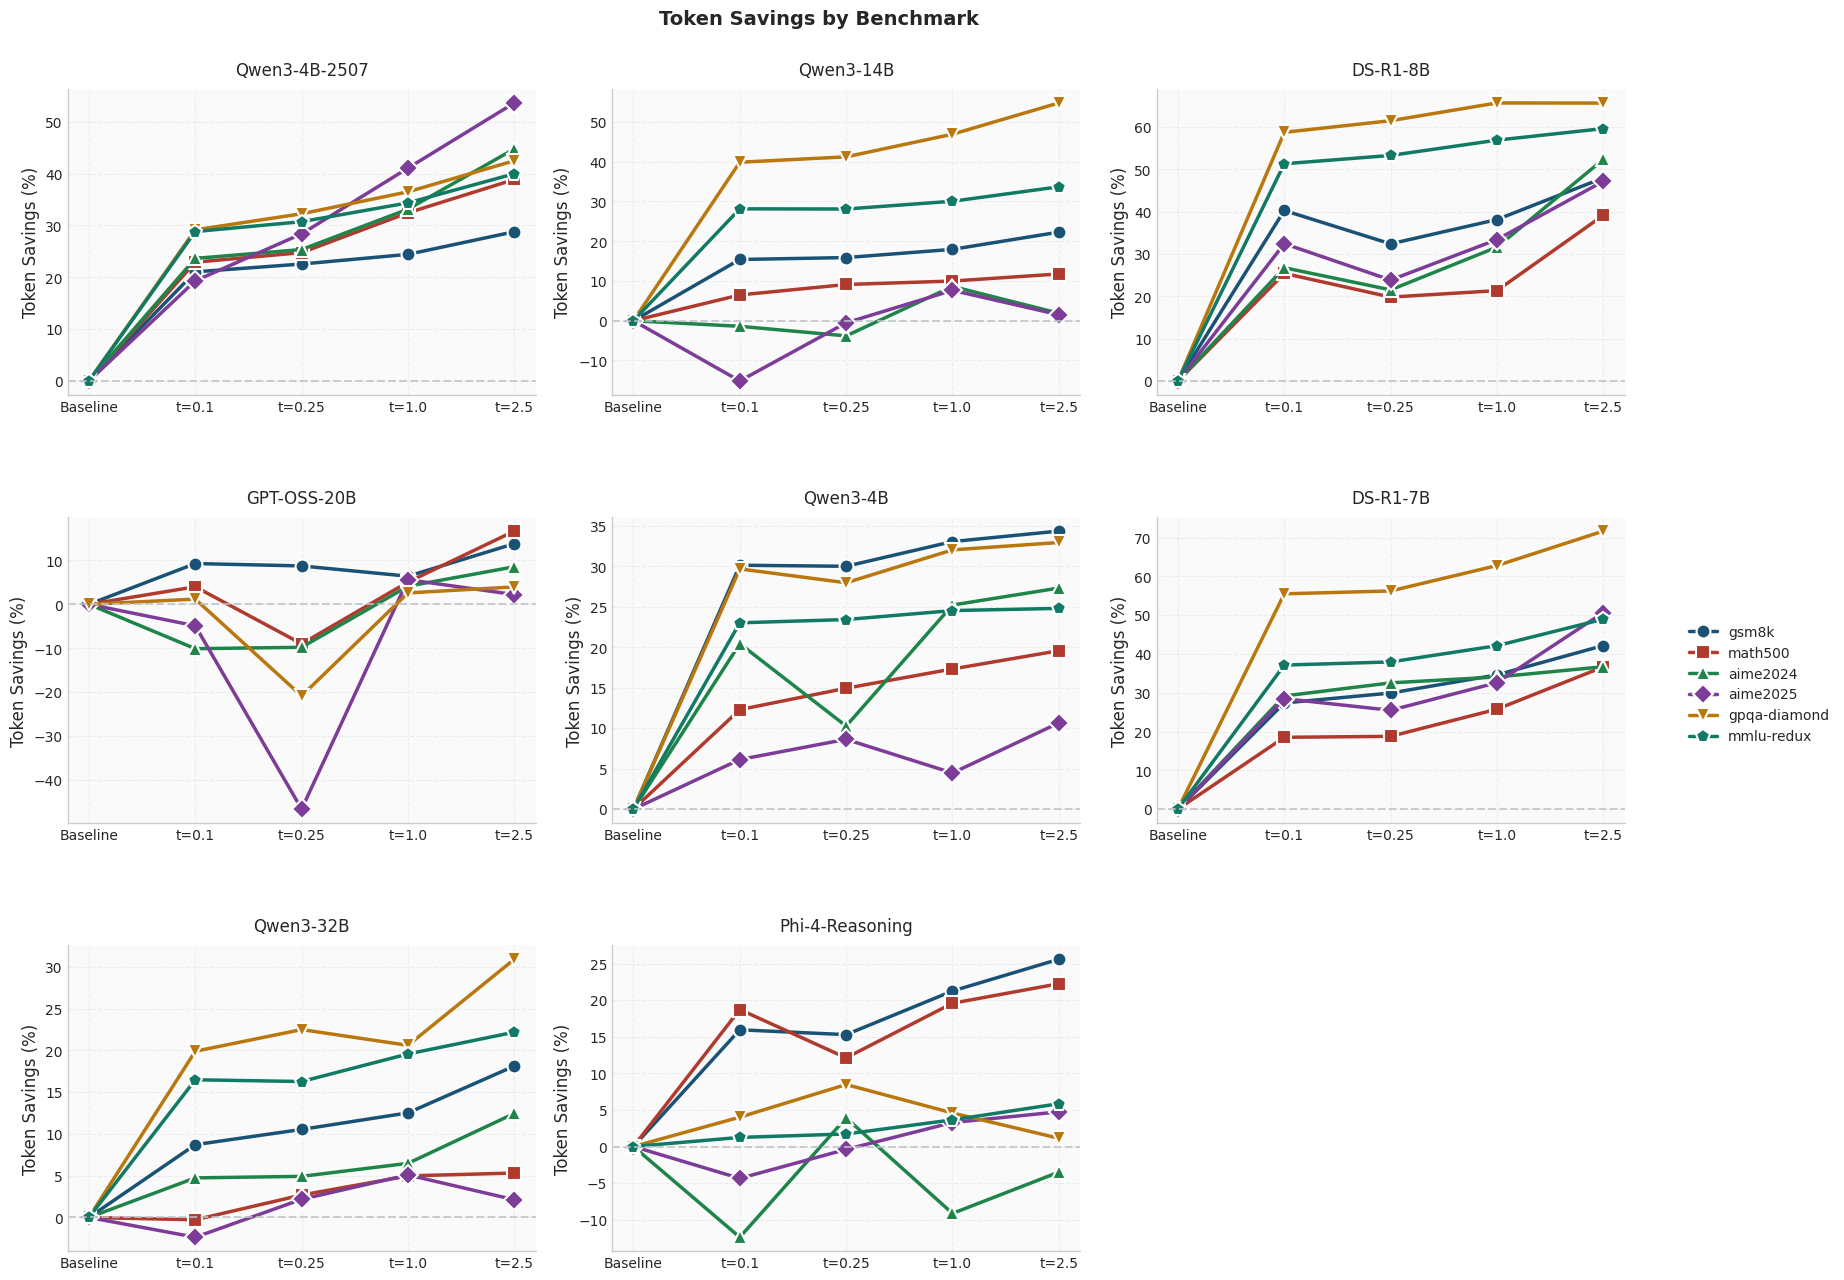

In [5]:
num_models = len(filtered_rollout_data)
if num_models == 0:
    print("No data available for this plot.")
else:
    fig, axes = create_dynamic_subplots(num_models, max_cols=3)

    for model_idx, (rollout_name, rollout_model_data) in enumerate(
        filtered_rollout_data.items()
    ):
        ax = axes[model_idx]
        mapped_name = model_name_map.get(rollout_name, rollout_name)
        display_name = short_names.get(mapped_name, rollout_name)

        for bench_idx, benchmark in enumerate(benchmarks):
            try:
                if benchmark not in rollout_model_data:
                    continue

                baseline_tokens = rollout_model_data[benchmark]["avg_token_length"]

                if (
                    mapped_name in filtered_thinkbrake_data
                    and benchmark in filtered_thinkbrake_data[mapped_name]
                ):
                    tb_data = filtered_thinkbrake_data[mapped_name][benchmark]
                    x_vals = ["Baseline"]
                    y_vals = [0]

                    for thresh in thresholds:
                        key = f"threshold_{thresh}"
                        if key in tb_data:
                            x_vals.append(f"t={thresh}")
                            token_savings = (
                                1 - tb_data[key]["avg_token_length"] / baseline_tokens
                            ) * 100
                            y_vals.append(token_savings)

                    color = line_colors[bench_idx % len(line_colors)]
                    ax.plot(
                        x_vals,
                        y_vals,
                        marker=markers[bench_idx % len(markers)],
                        linewidth=2.5,
                        markersize=10,
                        color=color,
                        label=benchmark,
                        markeredgecolor="white",
                        markeredgewidth=1.5,
                    )
            except Exception:
                continue

        ax.axhline(y=0, color="#BDC3C7", linestyle="--", alpha=0.8, linewidth=1.5)
        ax.set_ylabel("Token Savings (%)")
        ax.set_title(f"{display_name}", fontsize=12, pad=10)
        ax.grid(True, alpha=0.3, linestyle="--")
        ax.tick_params(axis="x", rotation=0)
        ax.set_facecolor("#FAFAFA")

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        ncol=1,
        fontsize=10,
        framealpha=0.9,
    )
    plt.suptitle(
        "Token Savings by Benchmark",
        fontsize=14,
        fontweight="bold",
        y=1.00,
    )
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.08, hspace=0.4)
    plt.show()

## Per-Model Bar Chart: Accuracy by Benchmark

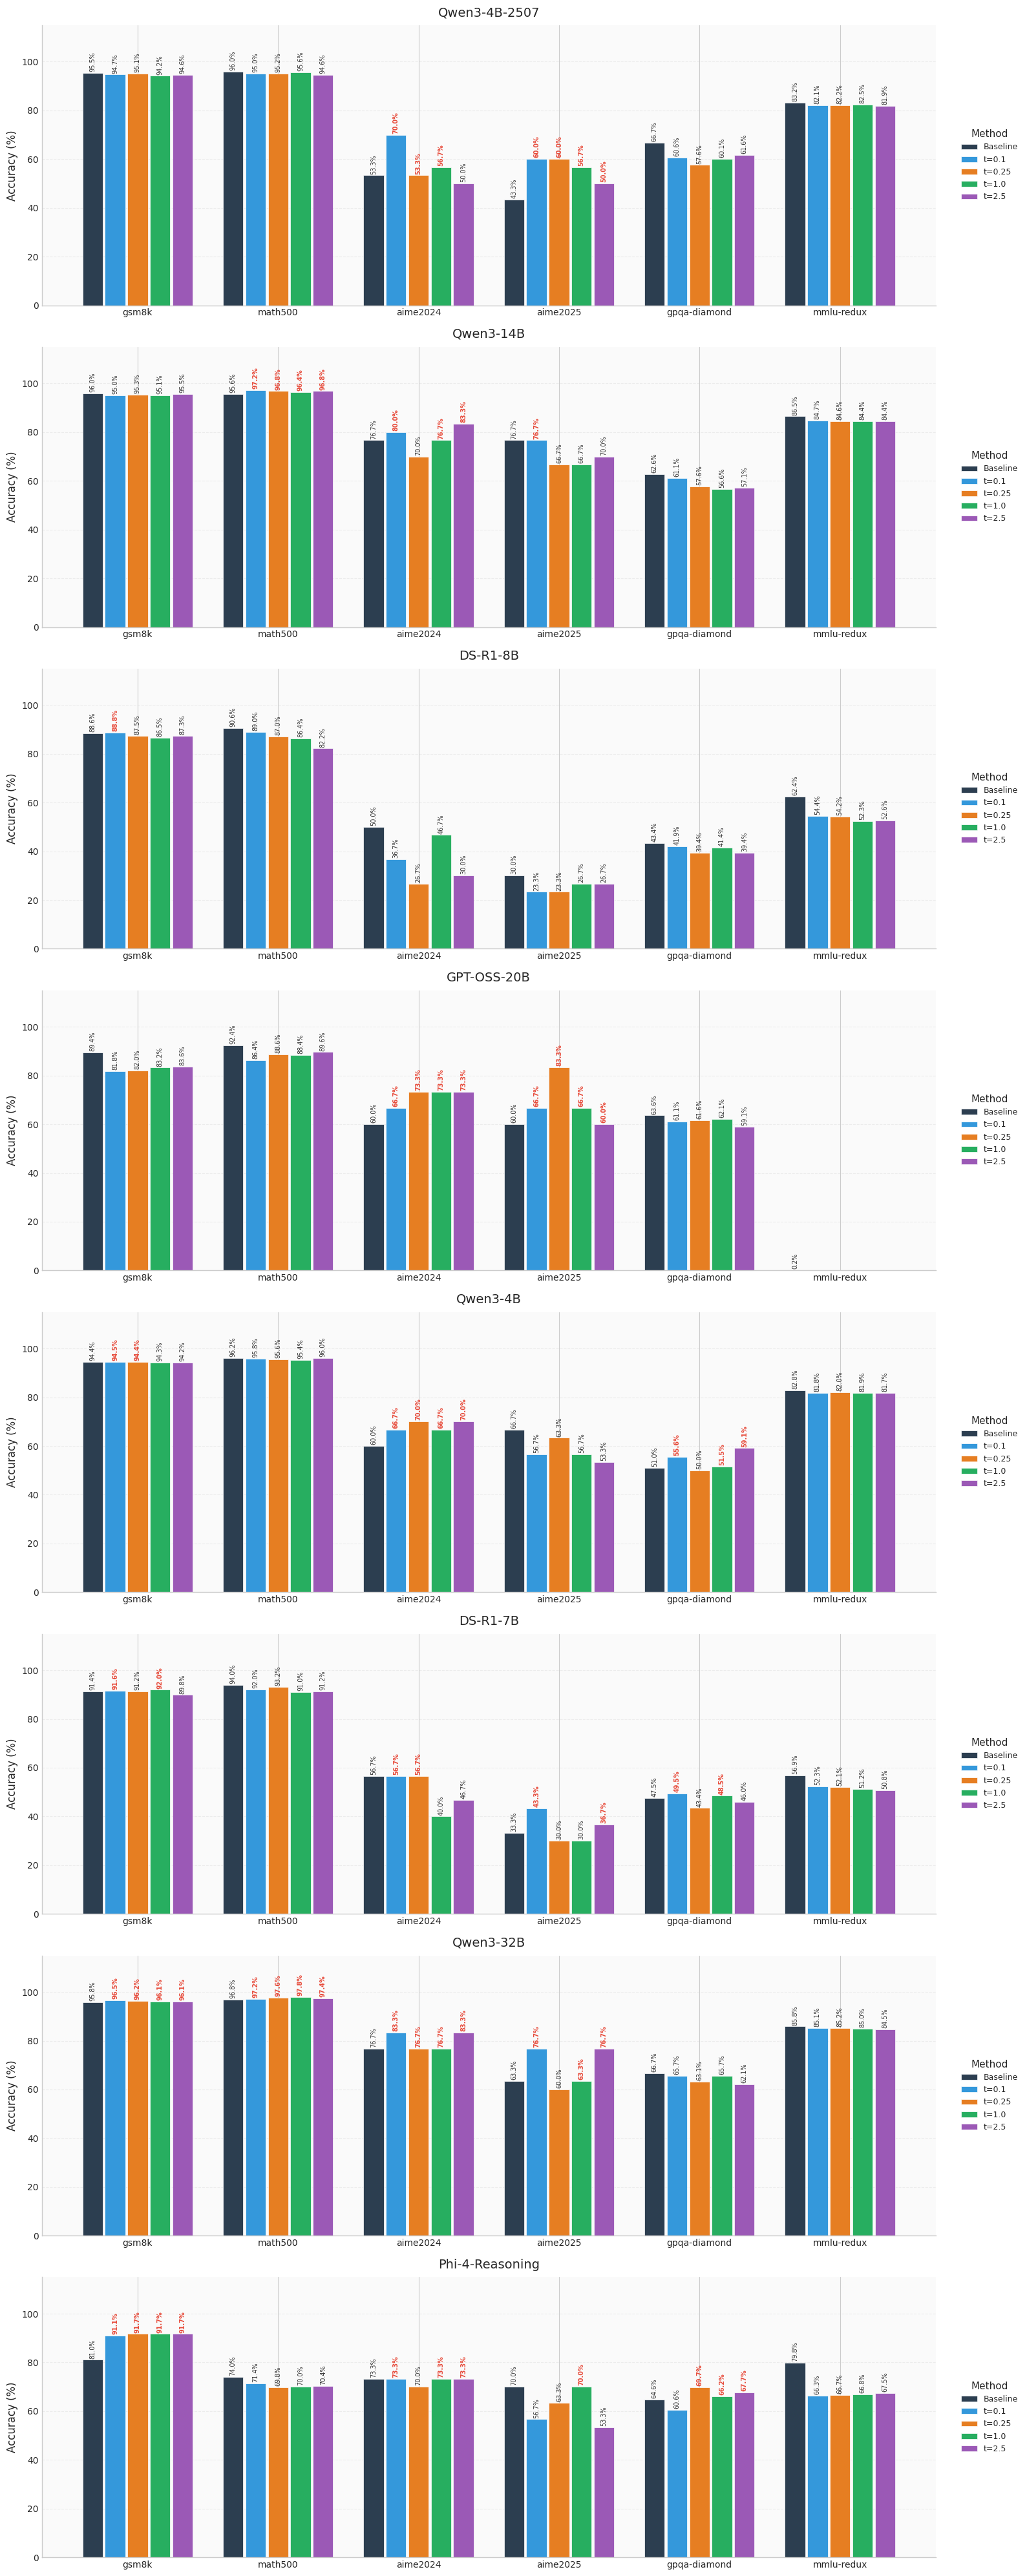

In [6]:
# Per-model bar chart: Accuracy by benchmark
num_models = len(filtered_rollout_data)
if num_models == 0:
    print("No data available for this plot.")
else:
    methods = ["Baseline"] + [f"t={t}" for t in thresholds]

    # Create a combined figure with subplots for each model
    fig, axes = plt.subplots(num_models, 1, figsize=(16, 5 * num_models))
    if num_models == 1:
        axes = [axes]

    for model_idx, (rollout_name, rollout_model_data) in enumerate(
        filtered_rollout_data.items()
    ):
        ax = axes[model_idx]
        mapped_name = model_name_map.get(rollout_name, rollout_name)
        display_name = short_names.get(mapped_name, rollout_name)

        model_benchmarks = []
        model_accuracies = {m: [] for m in methods}

        for benchmark in benchmarks:
            try:
                if benchmark not in rollout_model_data:
                    continue

                model_benchmarks.append(benchmark)
                model_accuracies["Baseline"].append(
                    rollout_model_data[benchmark]["accuracy"]
                )

                if (
                    mapped_name in filtered_thinkbrake_data
                    and benchmark in filtered_thinkbrake_data[mapped_name]
                ):
                    tb_data = filtered_thinkbrake_data[mapped_name][benchmark]
                    for thresh in thresholds:
                        key = f"threshold_{thresh}"
                        if key in tb_data:
                            model_accuracies[f"t={thresh}"].append(
                                tb_data[key]["accuracy"]
                            )
                        else:
                            model_accuracies[f"t={thresh}"].append(0)
                else:
                    for t in thresholds:
                        model_accuracies[f"t={t}"].append(0)
            except Exception:
                continue

        if model_benchmarks:
            x = np.arange(len(model_benchmarks))
            n_methods = len(methods)
            width = 0.8 / n_methods

            for i, method in enumerate(methods):
                try:
                    if model_accuracies[method]:
                        bars = ax.bar(
                            x + (i - n_methods / 2 + 0.5) * width,
                            model_accuracies[method],
                            width * 0.9,
                            label=method,
                            color=bar_colors[i % len(bar_colors)],
                            edgecolor="white",
                            linewidth=0.5,
                        )
                        # Add percentage labels on bars
                        for bar_idx, (bar, val) in enumerate(
                            zip(bars, model_accuracies[method])
                        ):
                            if val > 0:
                                # Check if this threshold beats baseline
                                baseline_val = model_accuracies["Baseline"][bar_idx]
                                if method != "Baseline" and val >= baseline_val:
                                    text_color = (
                                        "#E74C3C"  # Red for better than baseline
                                    )
                                    fontweight = "bold"
                                else:
                                    text_color = "#333333"
                                    fontweight = "normal"
                                ax.text(
                                    bar.get_x() + bar.get_width() / 2,
                                    bar.get_height() + 0.5,
                                    f"{val:.1f}%",
                                    ha="center",
                                    va="bottom",
                                    fontsize=7,
                                    color=text_color,
                                    fontweight=fontweight,
                                    rotation=90,
                                )
                except Exception:
                    continue

            ax.set_ylabel("Accuracy (%)")
            ax.set_title(f"{display_name}", fontsize=14, pad=10)
            ax.set_xticks(x)
            ax.set_xticklabels(model_benchmarks, rotation=0, ha="center")
            # Move legend outside the plot (to the right)
            ax.legend(
                loc="center left",
                bbox_to_anchor=(1.02, 0.5),
                fontsize=9,
                framealpha=0.9,
                ncol=1,
                title="Method",
            )
            ax.grid(True, alpha=0.3, axis="y", linestyle="--")
            ax.set_ylim(0, 115)
            ax.set_facecolor("#FAFAFA")

    plt.tight_layout()
    plt.show()

## Load Detailed Results Data

In [7]:
def load_all_detailed_results(model_dirs, benchmarks, best_threshold="0.25"):
    all_results = {}

    for model_dir in model_dirs:
        all_results[model_dir] = {}
        for benchmark in benchmarks:
            rollout_results = load_detailed_results(model_dir, benchmark, "rollout")
            thinkbrake_results = load_detailed_results(
                model_dir, benchmark, f"threshold_{best_threshold}"
            )

            if rollout_results and thinkbrake_results:
                all_results[model_dir][benchmark] = {
                    "rollout": rollout_results,
                    "thinkbrake": thinkbrake_results,
                }

    return all_results

In [8]:
BEST_THRESHOLD = 0.1
detailed_results = load_all_detailed_results(
    INCLUDE_MODELS, INCLUDE_BENCHMARKS, BEST_THRESHOLD
)

## Confusion Matrix

In [9]:
from math_verify import parse, verify
import re


def extract_multiple_choice_answer(response: str) -> str:
    patterns = [
        r'["\*]*answer["\*]*\s*[:=]\s*["\']?([A-Da-d])["\']?',
        r"(?:the\s+)?answer\s+is[:\s]*([A-Da-d])\b",
        r"final\s+answer[:\s]*([A-Da-d])\b",
        r"(?:choice|option)[:\s]*([A-Da-d])\b",
        r"\b([A-Da-d])\s*$",
    ]

    for pattern in patterns:
        matches = re.findall(pattern, response, re.IGNORECASE)
        if matches:
            return matches[-1].upper()

    standalone_matches = re.findall(r"\b([A-Da-d])\b", response)
    if standalone_matches:
        return standalone_matches[-1].upper()

    return ""


def verify_multiple_choice(ground_truth: str, predicted: str) -> bool:
    """Verify if the predicted multiple choice answer matches the ground truth."""
    if not predicted:
        return False
    return ground_truth.upper().strip() == predicted.upper().strip()


def evaluate_item(item: dict, is_multiple_choice: bool) -> bool:
    """
    Evaluate a single item using the same logic as evaluate.py
    """
    if is_multiple_choice:
        ground_truth = item["answer"]
        predicted = extract_multiple_choice_answer(item["response"])
        return verify_multiple_choice(ground_truth, predicted)
    else:
        # Math evaluation using math_verify
        try:
            ground_truth = parse(f"${item['answer']}$")
            predicted = parse(item["response"])
            return verify(ground_truth, predicted)
        except Exception:
            return False


def compute_confusion_matrix(rollout_results, thinkbrake_results, benchmark):
    """Compute confusion matrix comparing rollout (baseline) vs thinkbrake results"""
    rollout_dict = {r["id"]: r for r in rollout_results}
    thinkbrake_dict = {r["id"]: r for r in thinkbrake_results}

    # Determine if it's a multiple choice benchmark
    general_benchmarks = ["gpqa-diamond", "mmlu-redux"]
    is_multiple_choice = benchmark in general_benchmarks

    both_correct = 0
    only_rollout_correct = 0
    only_thinkbrake_correct = 0
    both_wrong = 0

    # Find common IDs
    common_ids = set(rollout_dict.keys()) & set(thinkbrake_dict.keys())

    for pid in common_ids:
        rollout_item = rollout_dict[pid]
        tb_item = thinkbrake_dict[pid]

        # Evaluate using the same method as evaluate.py
        rollout_correct = evaluate_item(rollout_item, is_multiple_choice)
        tb_correct = evaluate_item(tb_item, is_multiple_choice)

        if rollout_correct and tb_correct:
            both_correct += 1
        elif rollout_correct and not tb_correct:
            only_rollout_correct += 1
        elif not rollout_correct and tb_correct:
            only_thinkbrake_correct += 1
        else:
            both_wrong += 1

    return (
        both_correct,
        only_rollout_correct,
        only_thinkbrake_correct,
        both_wrong,
        len(common_ids),
    )

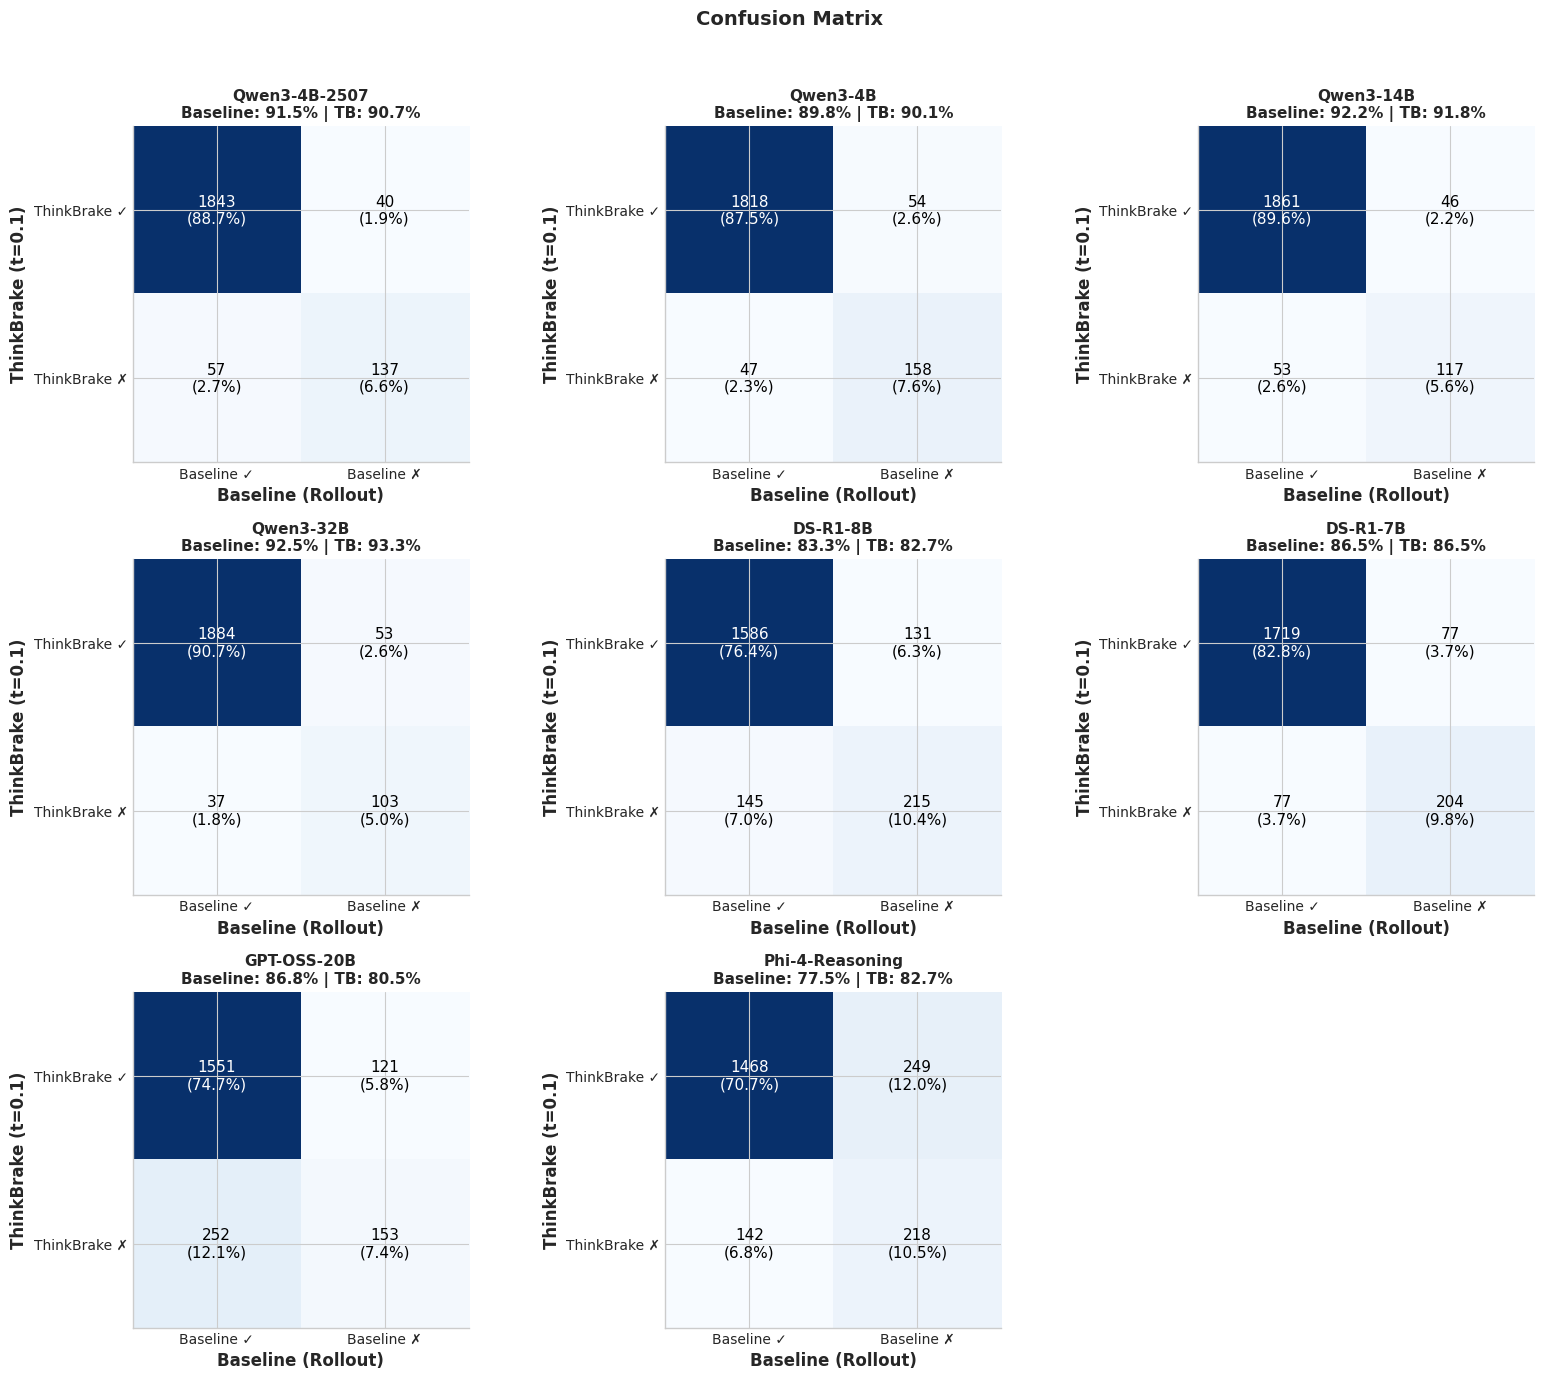

In [10]:
confusion_data = {}

for model_dir, benchmarks_data in detailed_results.items():
    display_name = short_names.get(model_name_map.get(model_dir, model_dir), model_dir)
    confusion_data[display_name] = {}

    for benchmark, data in benchmarks_data.items():
        if data["rollout"] and data["thinkbrake"]:
            cm = compute_confusion_matrix(
                data["rollout"], data["thinkbrake"], benchmark
            )
            confusion_data[display_name][benchmark] = {
                "both_correct": cm[0],
                "only_rollout": cm[1],
                "only_thinkbrake": cm[2],
                "both_wrong": cm[3],
                "total": cm[4],
            }


n_models = len([m for m in confusion_data if confusion_data[m]])
if n_models > 0:
    fig, axes = create_dynamic_subplots(n_models, max_cols=3)

    for idx, (model_name, bench_data) in enumerate(confusion_data.items()):
        if not bench_data:
            continue
        ax = axes[idx]

        total_both_correct = sum(d["both_correct"] for d in bench_data.values())
        total_only_rollout = sum(d["only_rollout"] for d in bench_data.values())
        total_only_tb = sum(d["only_thinkbrake"] for d in bench_data.values())
        total_both_wrong = sum(d["both_wrong"] for d in bench_data.values())
        total = sum(d["total"] for d in bench_data.values())

        # Calculate accuracies
        baseline_acc = (
            (total_both_correct + total_only_rollout) / total * 100 if total > 0 else 0
        )
        tb_acc = (total_both_correct + total_only_tb) / total * 100 if total > 0 else 0

        # Create confusion matrix
        # Rows: ThinkBrake (Correct/Wrong), Cols: Baseline (Correct/Wrong)
        cm = np.array(
            [
                [
                    total_both_correct,
                    total_only_tb,
                ],  # TB Correct: Both correct, Only TB correct
                [
                    total_only_rollout,
                    total_both_wrong,
                ],  # TB Wrong: Only Baseline correct, Both wrong
            ]
        )

        # Plot heatmap
        im = ax.imshow(cm, cmap="Blues")

        # Add labels - fixed orientation
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xticklabels(["Baseline ✓", "Baseline ✗"])
        ax.set_yticklabels(["ThinkBrake ✓", "ThinkBrake ✗"])
        ax.set_xlabel("Baseline (Rollout)", fontweight="bold")
        ax.set_ylabel(f"ThinkBrake (t={BEST_THRESHOLD})", fontweight="bold")

        # Add text annotations
        for i in range(2):
            for j in range(2):
                pct = cm[i, j] / total * 100 if total > 0 else 0
                text = ax.text(
                    j,
                    i,
                    f"{cm[i, j]}\n({pct:.1f}%)",
                    ha="center",
                    va="center",
                    fontsize=11,
                    color="white" if cm[i, j] > cm.max() / 2 else "black",
                )

        ax.set_title(
            f"{model_name}\nBaseline: {baseline_acc:.1f}% | TB: {tb_acc:.1f}%",
            fontsize=11,
            fontweight="bold",
        )

    plt.suptitle(
        "Confusion Matrix",
        fontsize=14,
        fontweight="bold",
        y=1.02,
    )
    plt.tight_layout()
    plt.show()

## Confusion Matrix by Benchmark

각 벤치마크별로 Baseline과 ThinkBrake의 정답 일치/불일치 패턴을 분석합니다.

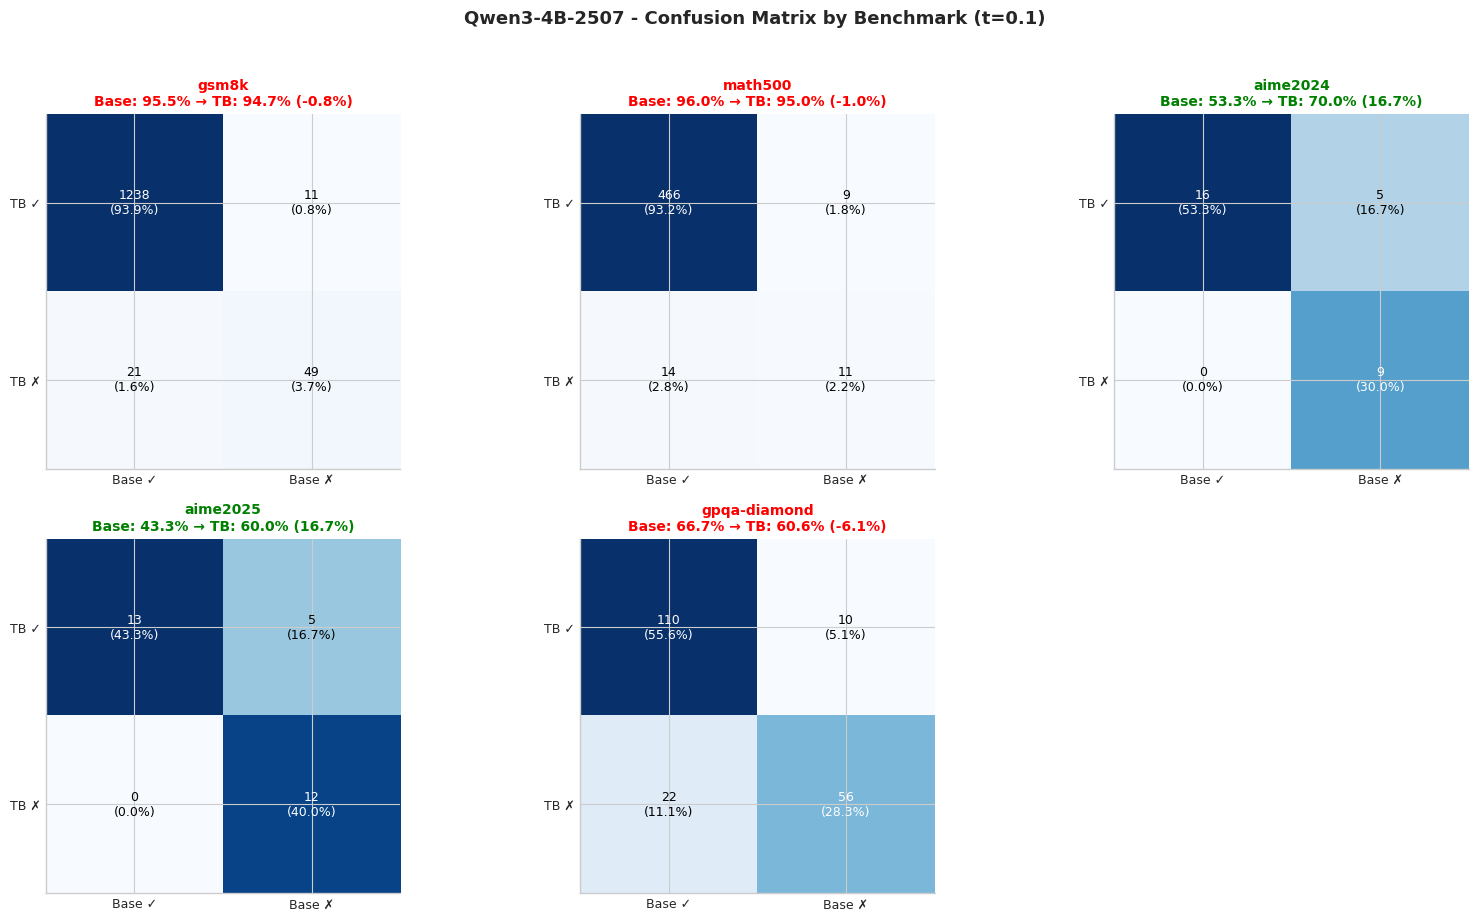

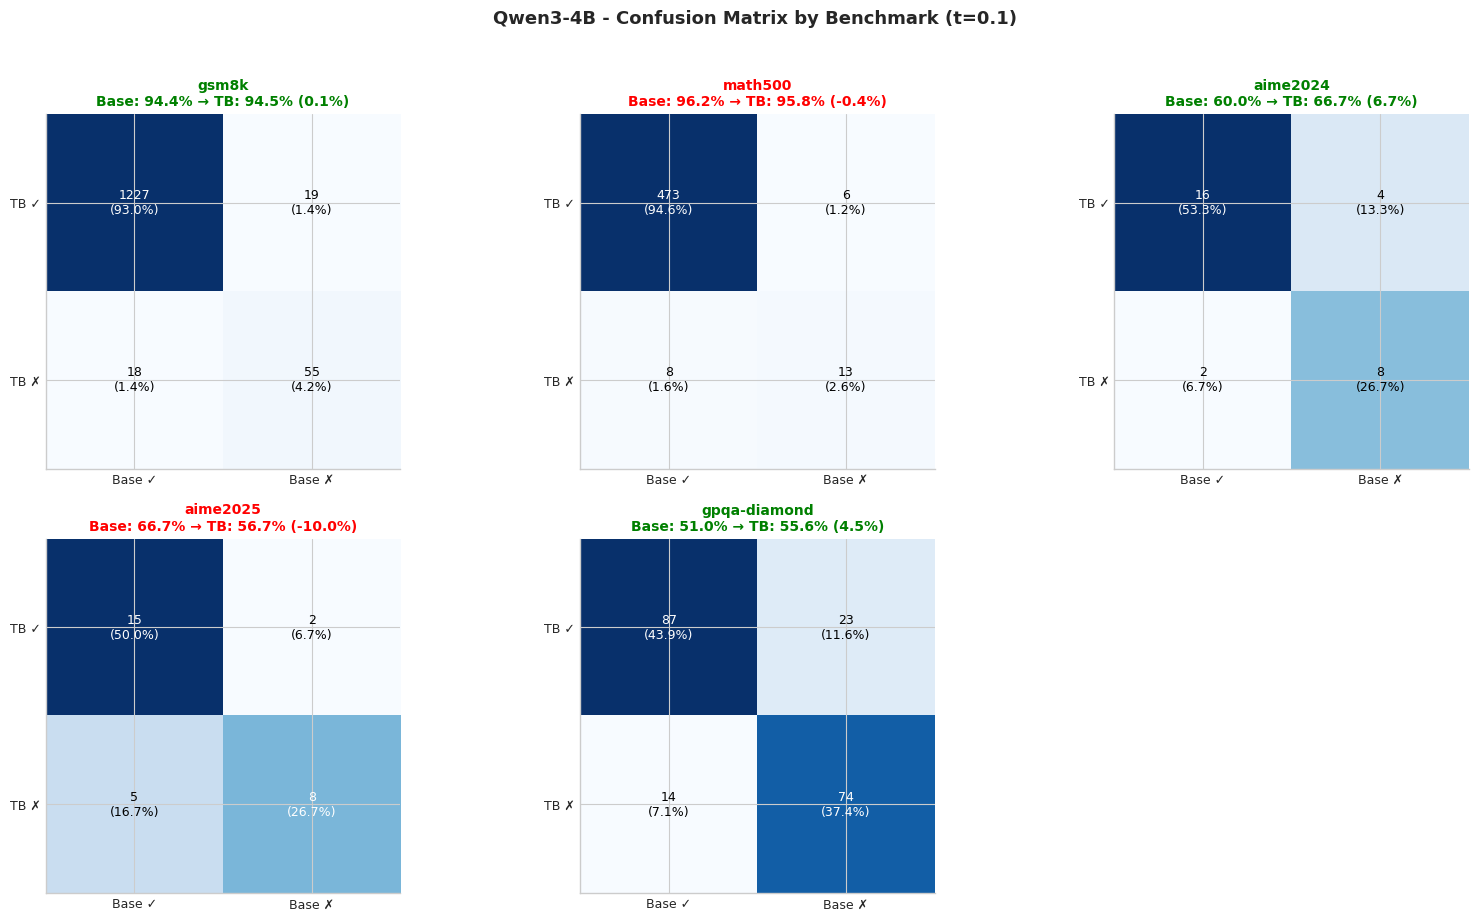

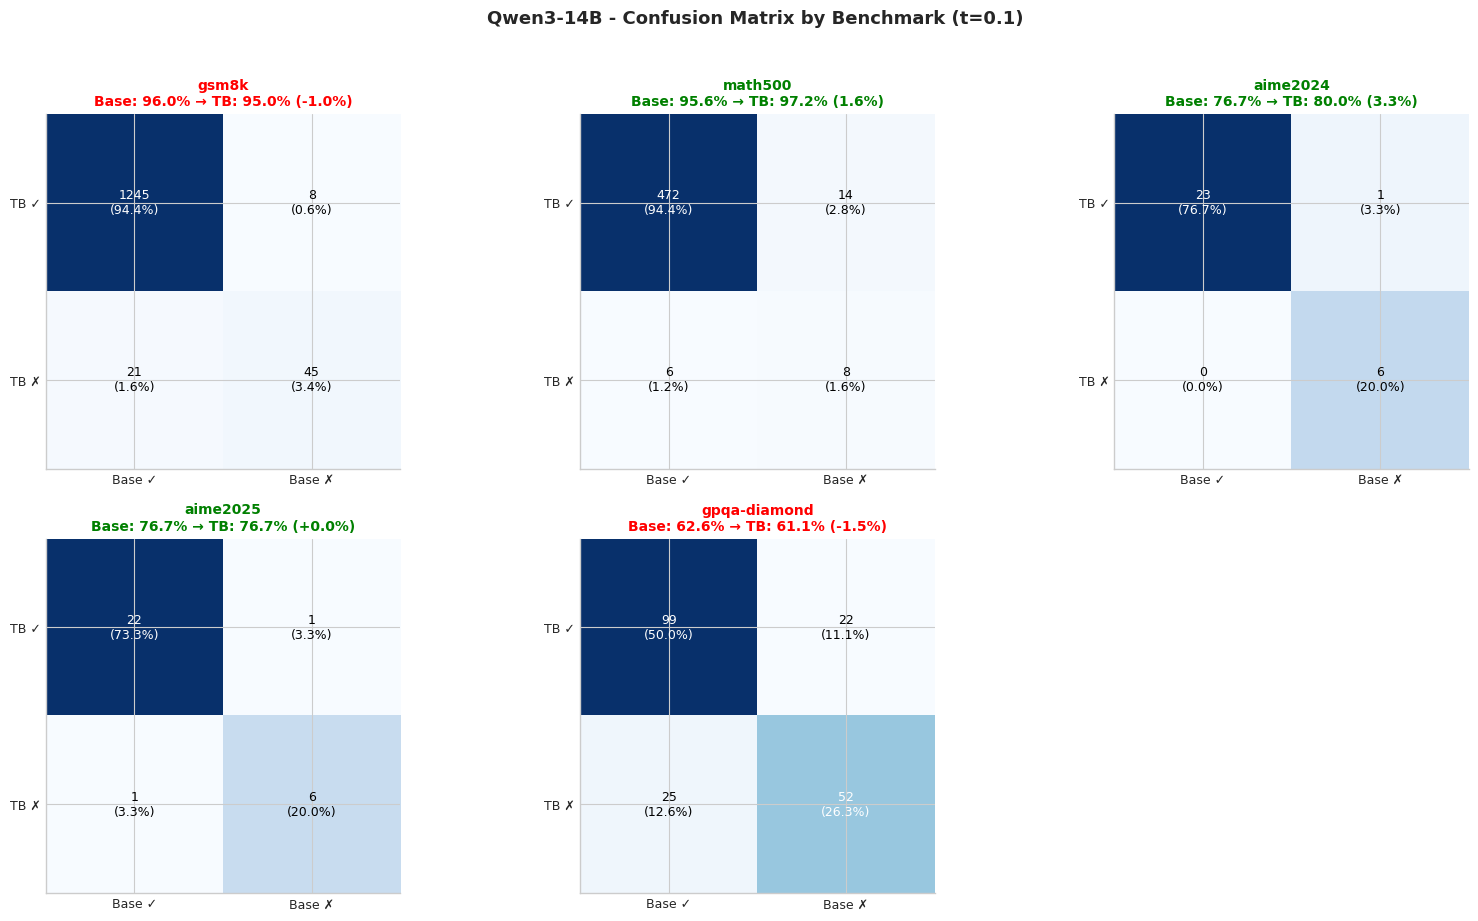

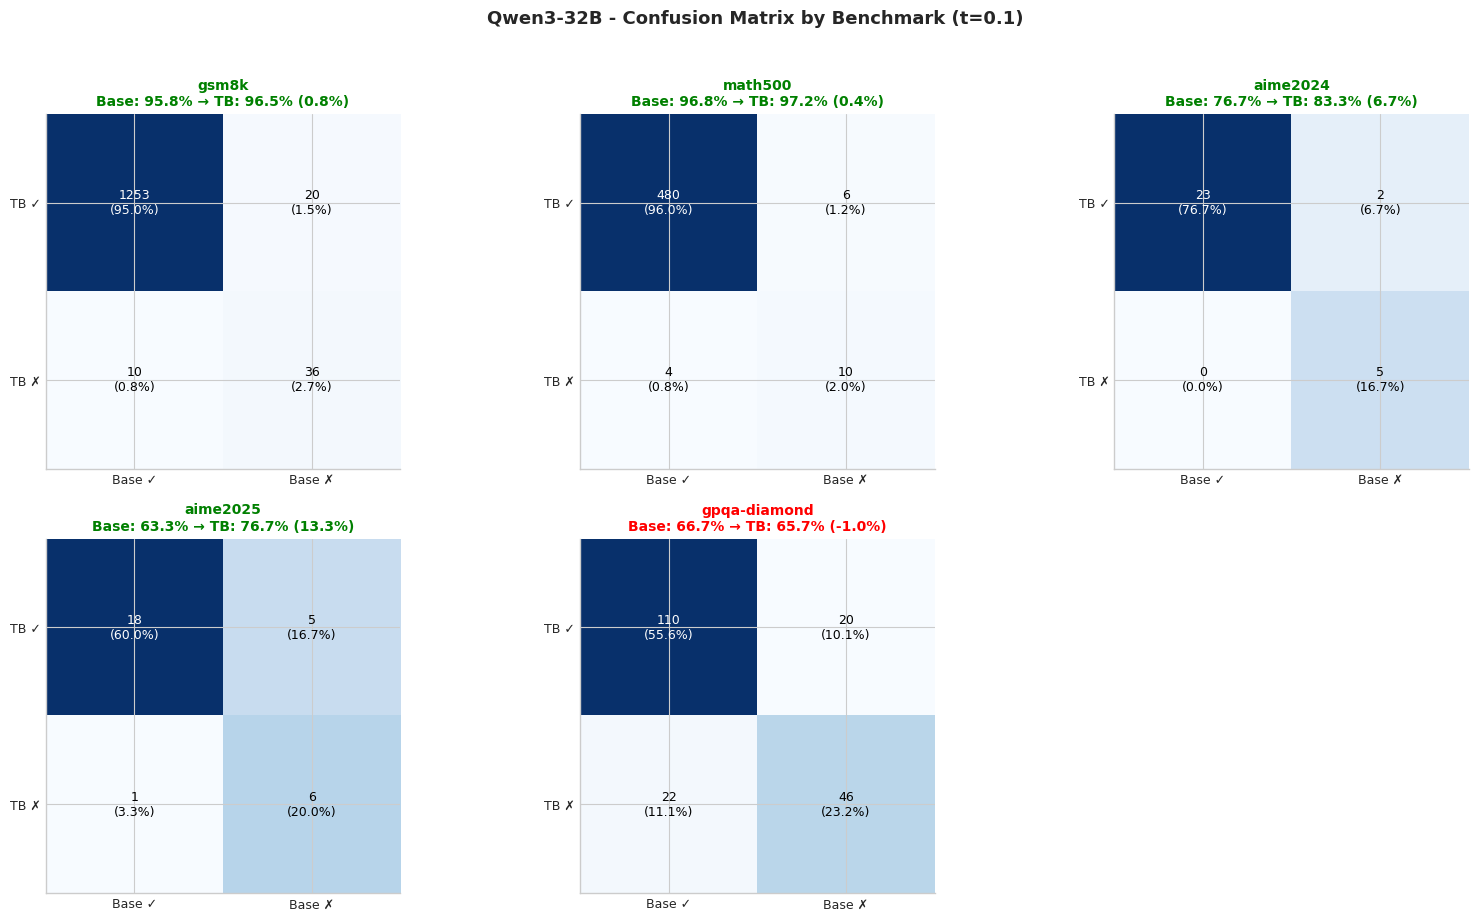

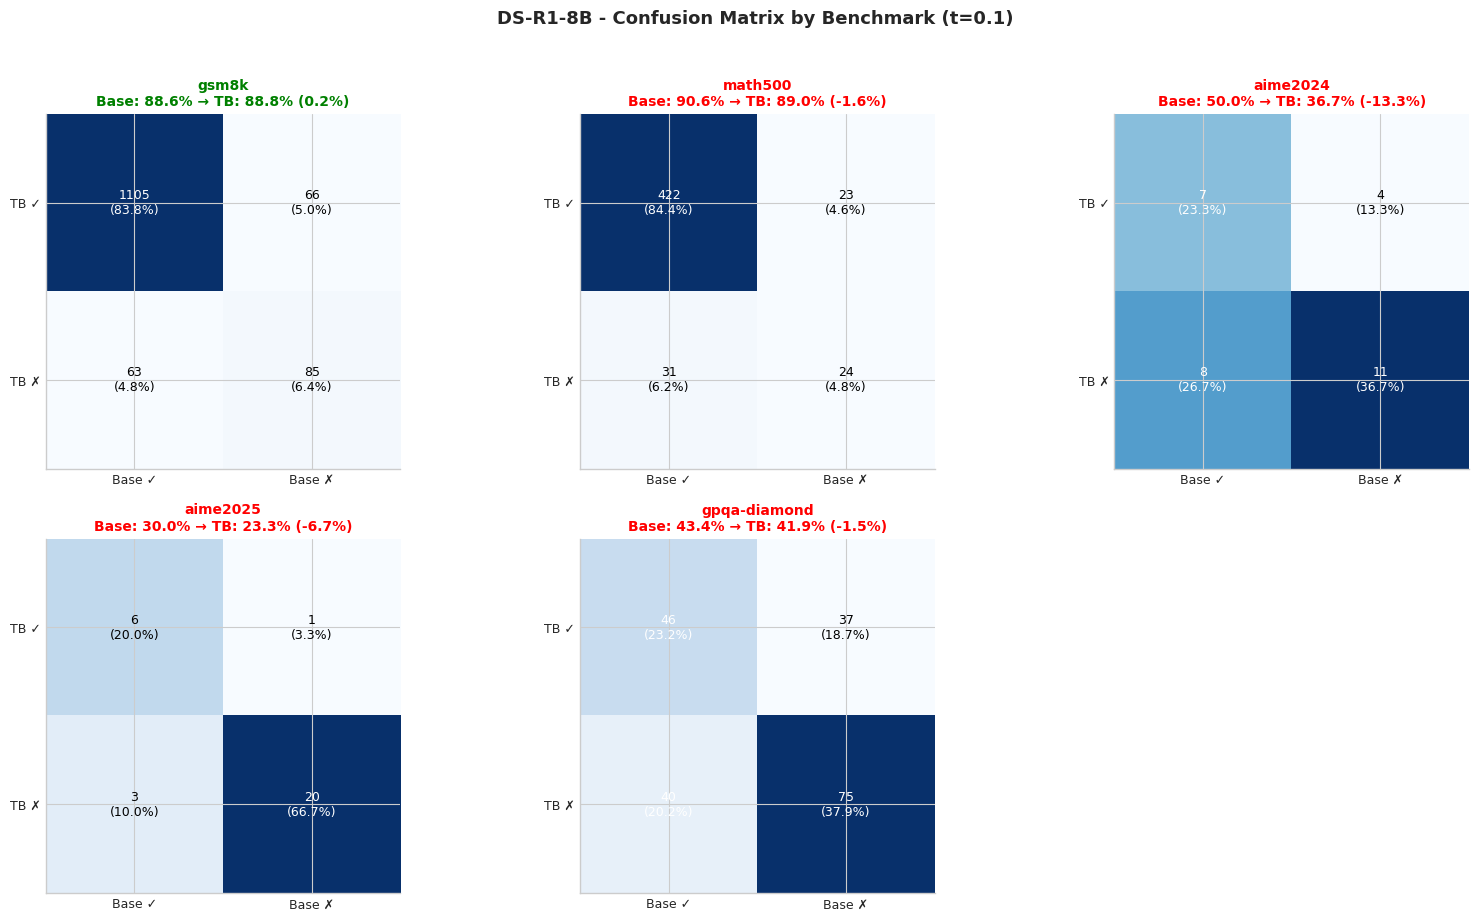

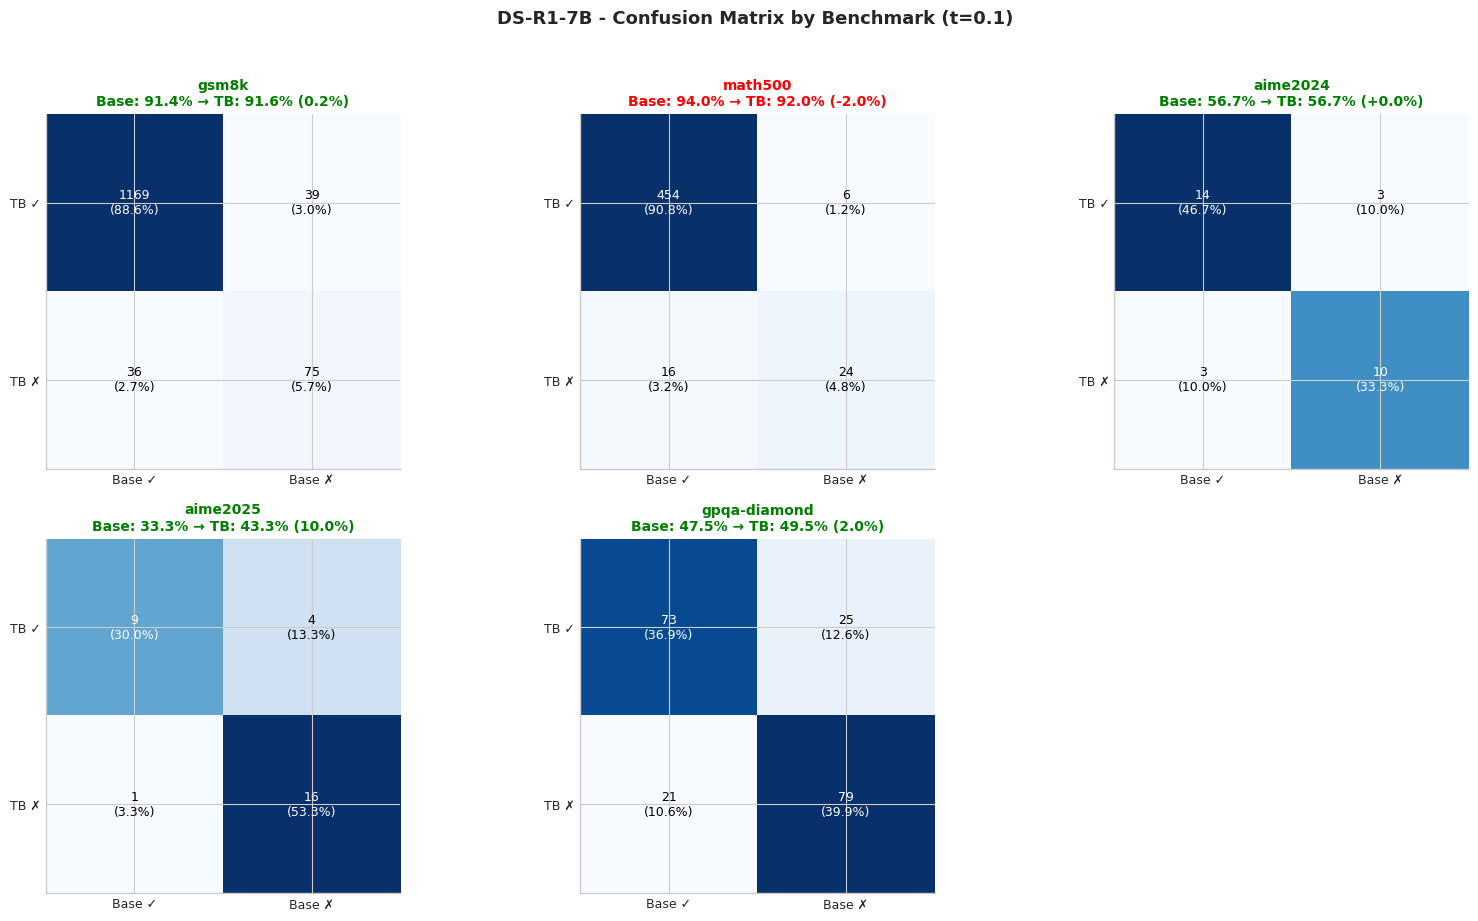

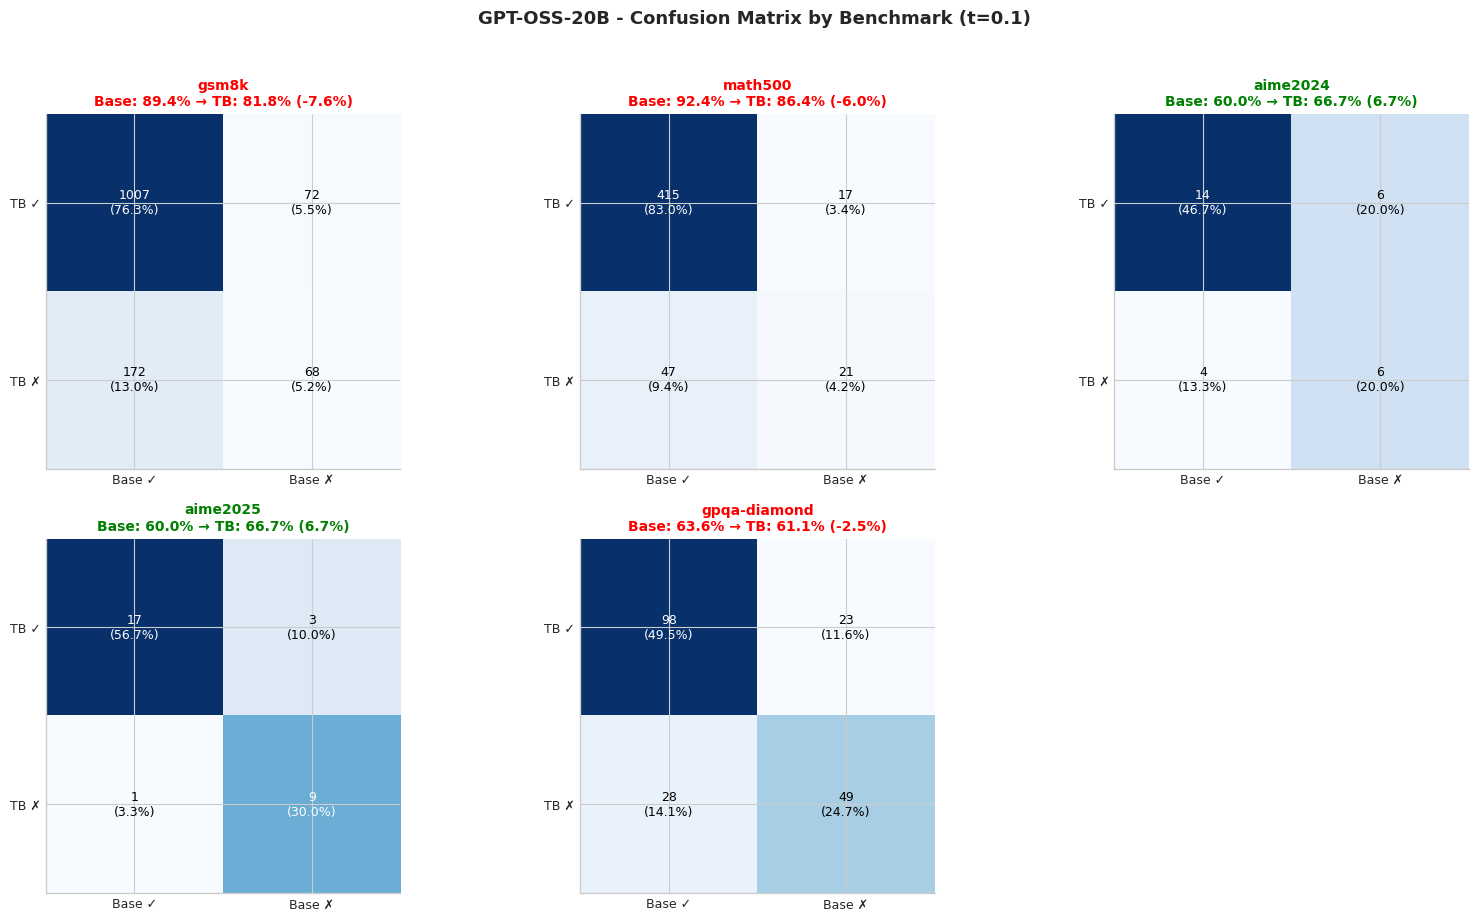

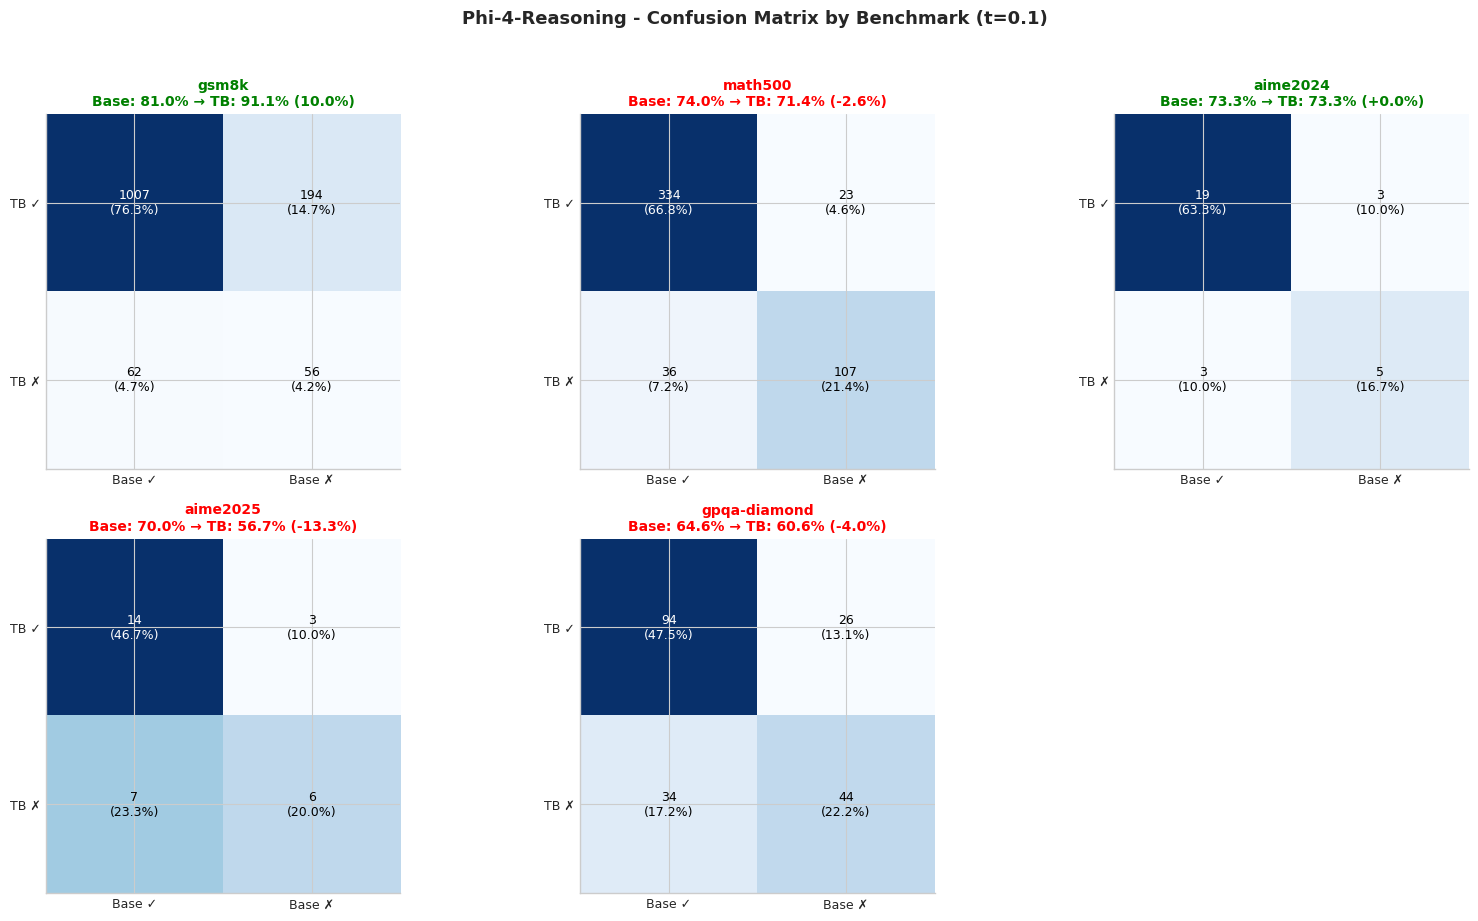

In [11]:
# Confusion Matrix by Benchmark for each model
for model_dir, benchmarks_data in detailed_results.items():
    display_name = short_names.get(model_name_map.get(model_dir, model_dir), model_dir)

    # Get benchmarks that have data
    available_benchmarks = [b for b in INCLUDE_BENCHMARKS if b in benchmarks_data]
    n_benchmarks = len(available_benchmarks)

    if n_benchmarks == 0:
        continue

    fig, axes = create_dynamic_subplots(n_benchmarks, max_cols=3)

    for idx, benchmark in enumerate(available_benchmarks):
        ax = axes[idx]
        data = benchmarks_data[benchmark]

        if not data["rollout"] or not data["thinkbrake"]:
            continue

        cm_result = compute_confusion_matrix(
            data["rollout"], data["thinkbrake"], benchmark
        )
        both_correct, only_rollout, only_tb, both_wrong, total = cm_result

        # Calculate accuracies
        baseline_acc = (both_correct + only_rollout) / total * 100 if total > 0 else 0
        tb_acc = (both_correct + only_tb) / total * 100 if total > 0 else 0
        diff = tb_acc - baseline_acc

        # Create confusion matrix
        cm = np.array(
            [
                [both_correct, only_tb],
                [only_rollout, both_wrong],
            ]
        )

        # Plot heatmap
        im = ax.imshow(cm, cmap="Blues")

        # Add labels
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xticklabels(["Base ✓", "Base ✗"], fontsize=9)
        ax.set_yticklabels(["TB ✓", "TB ✗"], fontsize=9)

        # Add text annotations
        for i in range(2):
            for j in range(2):
                pct = cm[i, j] / total * 100 if total > 0 else 0
                ax.text(
                    j,
                    i,
                    f"{cm[i, j]}\n({pct:.1f}%)",
                    ha="center",
                    va="center",
                    fontsize=9,
                    color="white" if cm[i, j] > cm.max() / 2 else "black",
                )

        # Title with accuracy comparison
        diff_color = "green" if diff >= 0 else ("red" if diff < 0 else "black")
        diff_sign = "+" if diff == 0 else ""
        ax.set_title(
            f"{benchmark}\nBase: {baseline_acc:.1f}% → TB: {tb_acc:.1f}% ({diff_sign}{diff:.1f}%)",
            fontsize=10,
            fontweight="bold",
            color=diff_color,
        )

    plt.suptitle(
        f"{display_name} - Confusion Matrix by Benchmark (t={BEST_THRESHOLD})",
        fontsize=13,
        fontweight="bold",
        y=1.02,
    )
    plt.tight_layout()
    plt.show()